Hello and welcome! 

This notebook's goal is to make accessible to anyone interested the methods of *A Well-Characterized HelioLinC Survey for Centaurs in Pan-STARRS1* (Kurlander et al, in prep) -- in particular, the nearest-neighbor classifier described in section 3.5 (Selection Function Fitting) and the multivariate test described in Appendix A. The input datasets used during the paper are included by default here: our set of discovered objects (`discovered_centaurs`), the literature dynamical+H model we compare to (`model_objects`), and our population of synthetic debiasing objects included in the search (`debiasing_objects`) and their discovery status (`debiasing_status`).

You can contact the author at jkurla@uw.edu

In [1]:
import pickle
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from matplotlib.gridspec import GridSpec
import numpy as np
from matplotlib.colors import LogNorm
from scipy.spatial import cKDTree


/Users/jake/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We load all the data from the survey:
- The nearest-neighbors classifier (`nn_classifier: scipy.spatial.cKDTree`)
- The apparent magnitudes and keplerian orbits of the debiasing Centaurs (`debiasing_objects: numpy.ndarray`)
- The boolean discovery state of the debiasing objects (`debiasing_status: numpy.ndarray`)
- The normalization for state vectors before using the nearest-neighbor classifier (`state_vector_stddevs numpy.ndarray`).
- The literature population's state vectors (`literature_states`: numpy.ndarray)
- The literature population's keplerian coordinates (`literature_keps: numpy.ndarray`)
- The literature population's absolute magnitudes (`literature_H: numpy.ndarray`)
- The discovered Centaurs' MPCORB entries (`discovered_centaurs: pandas.DataFrame`)

In [2]:
nn_classifier, debiasing_objects, debiasing_status, state_vector_stddevs = pickle.load(open("debiasing_nn_classifier.pkl", "rb"))
literature_states, literature_keps, literature_H = pickle.load(open('literature_states_keps_and_H.pkl', 'rb'))
discovered_centaurs = pd.read_csv("debiasing_centaurs.csv")

In [3]:
%%time
literature_states /= state_vector_stddevs
literature_keps = np.array(literature_keps)

literature_distances, literature_neighbors = nn_classifier.query(literature_states)

CPU times: user 11.1 s, sys: 21.2 ms, total: 11.1 s
Wall time: 11.2 s


In [4]:
# Unpacking Keplerian coordinates and masking the literature population to just the 'discovered' objects


literature_discovery_mask = debiasing_status[literature_neighbors]

literature_predicted_a, literature_predicted_e, literature_predicted_i, literature_predicted_argperi, \
literature_predicted_longnode, literature_predicted_M = literature_keps.T[literature_discovery_mask].T

literature_predicted_H = literature_H[literature_discovery_mask]


centaur_a, centaur_e, centaur_i, centaur_argperi, centaur_longnode, centaur_H = discovered_centaurs[['a', 'e','i','Peri','Node', 'H']].values.T


In [5]:
n_debiased_discoveries = 44
n_literature_obs = 26116868 # Size of the original population (including m < 21, m > 23.5)
literature_p = np.sum(literature_discovery_mask)/n_literature_obs

print(np.sum(literature_discovery_mask), literature_p)

54638 0.0020920578991324686


In [6]:
scipy.stats.binom.ppf(0.00209, 54638, 0.025)

1263.0

In [7]:
%%time
xs = np.arange(10000, 35000)
ps = np.array([scipy.stats.binom(x, literature_p).cdf(n_debiased_discoveries) for x in xs])


CPU times: user 8.75 s, sys: 22.2 ms, total: 8.77 s
Wall time: 8.77 s


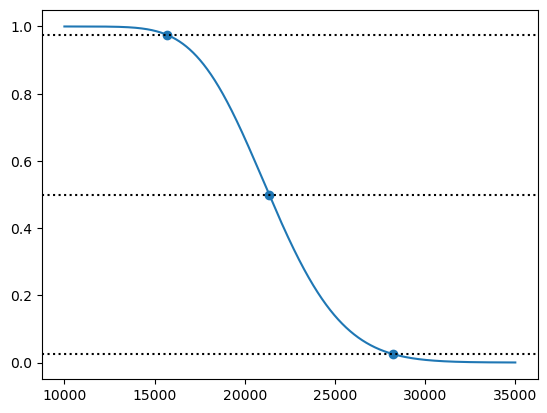

Population size 95% confidence range and center: 15696 21350 28226


In [8]:
p_975, p_5, p_025 = round(min(xs[(ps < 0.975)])), round(max(xs[0.5 < ps])), round(max(xs[(0.025 < ps)]))

plt.plot(xs, ps)
plt.axhline(0.025, ls=':', c='black')
plt.axhline(0.5, ls=':', c='black')
plt.axhline(0.975, ls=':', c='black')
plt.scatter([p_025, p_5, p_975], [0.025, 0.5, 0.975])
plt.show()
print(f'Population size 95% confidence range and center:', p_975, p_5, p_025)

In [9]:
a_result = scipy.stats.kstest(literature_predicted_a, centaur_a)
e_result = scipy.stats.kstest(literature_predicted_e, centaur_e)
i_result = scipy.stats.kstest(literature_predicted_i, centaur_i)
H_result = scipy.stats.kstest(literature_predicted_H, centaur_H)


In [10]:
round(a_result.pvalue, 2), round(e_result.pvalue, 2), round(i_result.pvalue, 2), round(H_result.pvalue, 2)

(0.26, 0.39, 0.08, 0.28)

/var/folders/tc/2vg3dffs52j1zh0v6v721ky40000gp/T/ipykernel_36675/2861016143.py:112: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  fig.legend(loc=(0.54, 0.56), prop={'size': 15})


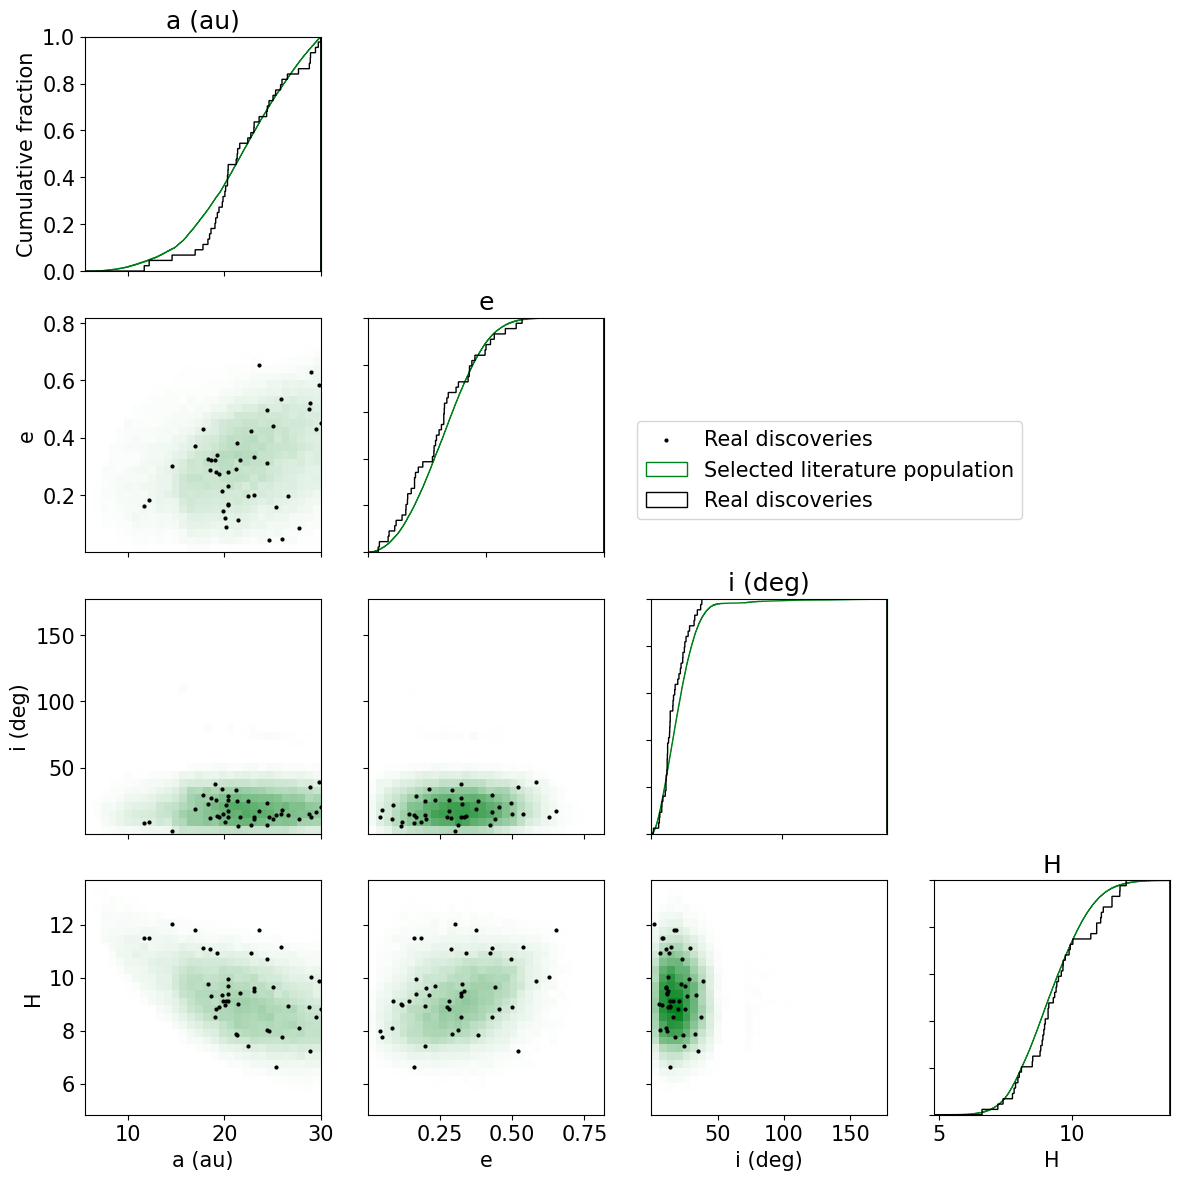

In [11]:
plt.style.use('default')
plt.rcParams.update({'figure.titlesize': 20,'font.size': 15, 'grid.alpha': 0.3, 'axes.labelsize': 15})
fig_width = 8

a_range = (np.min(literature_predicted_a), np.max(literature_predicted_a))
e_range = (0, 1)
i_range = (0, 180)
H_range = (np.min(literature_predicted_H), np.max(literature_predicted_H))

cmap = matplotlib.colors.LinearSegmentedColormap('from_dict', 
    {'red':  [(0.0,  1.0, 1.0), (1.0,  0.0, 0.0)],
             'green': [(0.0,  1.0, 1.0),(1.0,  0.5, 0.5)],
             'blue':  [(0.0,  1.0, 1.0),(1.0,  0.1, 0.1)]}
)
cmap.set_bad((0.2,0.2,0.7))

fig = plt.figure(figsize=(fig_width, fig_width))

modelc, datac = [0, 0.5, 0.1], [0, 0, 0]

plt.tight_layout()

gs = GridSpec(4, 4)

ae_joint = fig.add_subplot(gs[1,0])
ai_joint = fig.add_subplot(gs[2,0])
aH_joint = fig.add_subplot(gs[3,0])
marg_a = fig.add_subplot(gs[0,0])
ei_joint = fig.add_subplot(gs[2,1])
eH_joint = fig.add_subplot(gs[3,1])
marg_e = fig.add_subplot(gs[1,1])

iH_joint = fig.add_subplot(gs[3,2])
marg_H = fig.add_subplot(gs[3,3])

right_side = fig.add_subplot(gs[1, 2])
right_side.set_xticks([])
right_side.set_yticks([])
right_side.axis('off')
marg_i = fig.add_subplot(gs[2,2])

vmin, vmax = 0, 955.0


_, _, _, image = ae_joint.hist2d(literature_predicted_a, literature_predicted_e, cmap=cmap, bins=30, label='Biased model', vmin=vmin, vmax=vmax)
ae_joint.scatter(centaur_a, centaur_e, c='black', s=4, label='Real discoveries')

ai_joint.hist2d(literature_predicted_a, literature_predicted_i, cmap=cmap, bins=30, vmin=vmin, vmax=vmax)
ai_joint.scatter(centaur_a, centaur_i, c='black', s=4)

aH_joint.hist2d(literature_predicted_a, literature_predicted_H, cmap=cmap, bins=30, vmin=vmin, vmax=vmax)
aH_joint.scatter(centaur_a, centaur_H, c='black', s=4)

ei_joint.hist2d(literature_predicted_e, literature_predicted_i, cmap=cmap, bins=30, vmin=vmin, vmax=vmax)
ei_joint.scatter(centaur_e, centaur_i, c='black', s=4)

eH_joint.hist2d(literature_predicted_e, literature_predicted_H, cmap=cmap, bins=30, vmin=vmin, vmax=vmax)
eH_joint.scatter(centaur_e, centaur_H, c='black', s=4)

iH_joint.hist2d(literature_predicted_i, literature_predicted_H, cmap=cmap, bins=30,  vmin=vmin, vmax=vmax)
iH_joint.scatter(centaur_i, centaur_H, c='black', s=4)


marg_a.hist(literature_predicted_a, cumulative=True, range=a_range, bins=1000, histtype='step', density=True, label='Selected literature population', color=modelc)
marg_a.hist(centaur_a, cumulative=True, bins=1000, range=a_range, histtype='step', density=True, label='Real discoveries', color=datac)
marg_a.set_xlim(a_range)
marg_a.set_ylim((0, 1))

marg_e.hist(literature_predicted_e, cumulative=True, bins=1000, range=e_range, histtype='step', density=True, color=modelc)
marg_e.hist(centaur_e, cumulative=True, bins=1000, range=e_range, histtype='step', density=True, color=datac)
marg_e.set_xlim(e_range)
marg_e.set_ylim((0, 1))

marg_i.hist(literature_predicted_i, cumulative=True, bins=1000, range=i_range, histtype='step', density=True, color=modelc)
marg_i.hist(centaur_i, cumulative=True, bins=1000, range=i_range, histtype='step', density=True, color=datac)
marg_i.set_xlim(i_range)
marg_i.set_ylim((0, 1))

marg_H.hist(literature_predicted_H,cumulative=True, bins=1000, range=H_range, histtype='step', density=True, color=modelc)
marg_H.hist(centaur_H, cumulative=True, bins=1000, range=H_range, histtype='step', density=True, color=datac)
marg_H.set_xlim(H_range)
marg_H.set_ylim((0, 1))


for i in [marg_a, marg_i, marg_e, ai_joint, ae_joint, ei_joint]:
    i.set_xticklabels([])

for i in [marg_e, marg_i, marg_H, ei_joint, eH_joint, iH_joint]:
    i.set_yticklabels([])


ae_joint.set_ylabel('e')
ai_joint.set_ylabel('i (deg)')

aH_joint.set_ylabel('H')
aH_joint.set_xlabel('a (au)')

eH_joint.set_xlabel('e')
iH_joint.set_xlabel('i (deg)')


marg_H.set_xlabel('H')

marg_a.set_title('a (au)')
marg_a.set_ylabel('Cumulative fraction')

marg_e.set_title('e')
marg_i.set_title('i (deg)')
marg_H.set_title('H')

fig.set_size_inches(14,14)
fig.legend(loc=(0.54, 0.56), prop={'size': 15})
plt.show()

# Multivariate stats

Typically, in outer Solar System science, one wishes to compare whether a catalog $\mathcal{D} = \{a, e, i, \Omega, \omega, \mathcal{M}, H\}$ corresponds to a model $q(a,e,i,\Omega,\omega,\mathcal{M},H)$. These population models typically come from realizations of dynamical simulations, or from expectations given a hypothesis, and are forward-modelled to mimic the expectation of the survey biases with the use a survey simulator, turning this into an inherent two-sample hypothesis testing problem. The typical comparison, then, is done by performing a test such as the Kolmogorov-Smirnov test or its variants on the marginal distributions for one parameter, and a $p$-value being reported. 

The problem with such analyses is that such a test inherently requires the discrepancy to be one dimensional. To see that this is not the most general case, consider the following toy scenario:

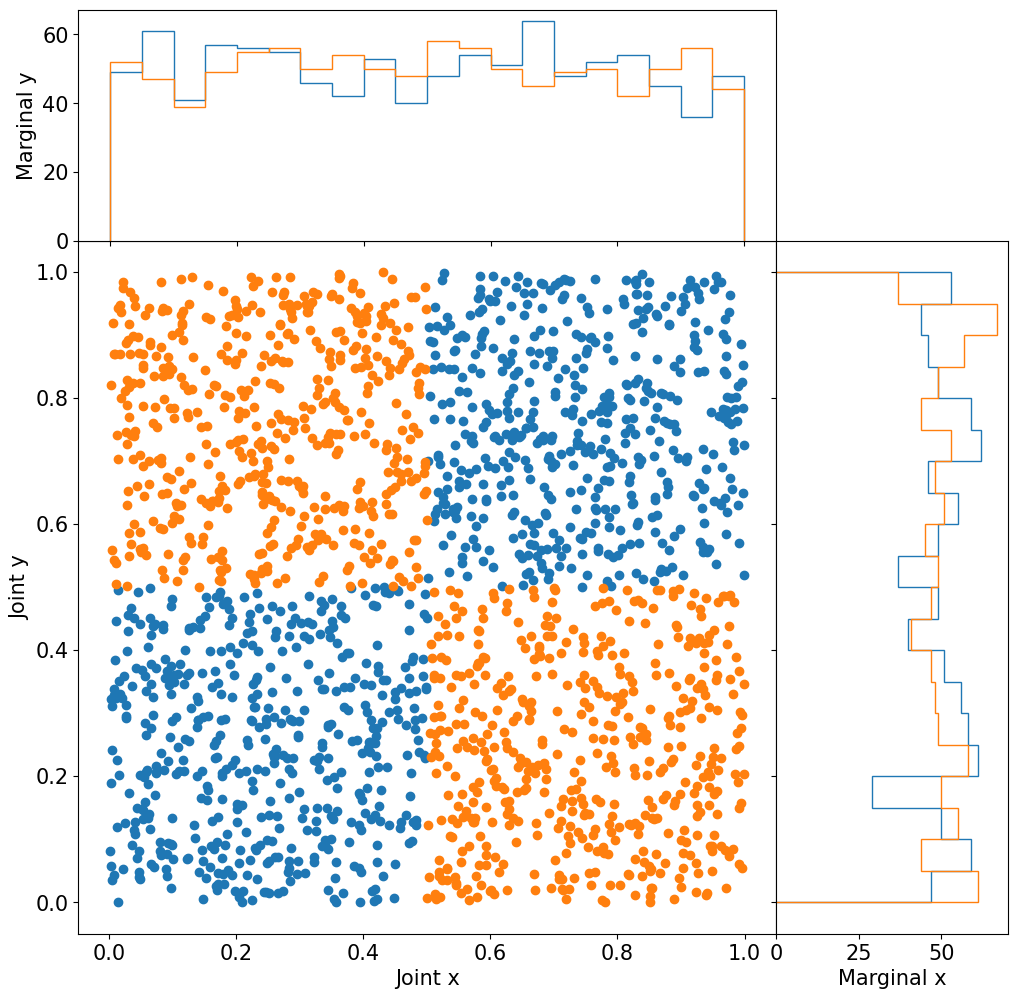

In [12]:
x1_a = 0.5*np.random.rand(500)
y1_a = 0.5*np.random.rand(500)

x1_b = 0.5 + 0.5*np.random.rand(500)
y1_b = 0.5 + 0.5*np.random.rand(500)

x1 = np.append(x1_a, x1_b)
y1 = np.append(y1_a, y1_b)

x2_a = 0.5+0.5*np.random.rand(500)
y2_a = 0.5*np.random.rand(500)

x2_b = 0.5*np.random.rand(500)
y2_b = 0.5 + 0.5*np.random.rand(500)

x2 = np.append(x2_a, x2_b)
y2 = np.append(y2_a, y2_b)



fig = plt.figure()

gs = GridSpec(4,4, hspace=0, wspace=0)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(x1,y1)
ax_marg_x.hist(x1, bins=20, histtype='step', range=[0, 1])
ax_marg_y.hist(y1,orientation="horizontal", bins=20, histtype='step', range=[0, 1])

ax_joint.scatter(x2,y2)
ax_marg_x.hist(x2, bins=20, histtype='step', range=[0, 1])
ax_marg_y.hist(y2,orientation="horizontal", bins=20, histtype='step', range=[0, 1])


# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Joint x')
ax_joint.set_ylabel('Joint y')

# Set labels on marginals
ax_marg_y.set_xlabel('Marginal x')
ax_marg_x.set_ylabel('Marginal y')
fig.set_size_inches(12,12)
plt.show()

As can be immediately seen, the two distributions are distinct in the $(x,y)$ plane, but have the same marginal distributions in either $x$ or $y$. 

We propose a divergence-based test two sample test to discriminate between the two cases. As is common in the machine learning literature, we use the Kullback-Leibler (KL) divergence. For a $n$-dimensional quantity $\mathbf{x}$, we have that the divergence between distributions $p$ and $q$ is 
$$ D_\mathrm{KL}(p||q) \equiv \int_{\mathbb{R}^n} \mathrm{d}\mathbf{x} \, p(\mathbf{x}) \log\left(\frac{p(\mathbf{x})}{q(\mathbf{x})}\right).$$
This divergence is 0 if $p$ and $q$ are identical, and increasing the value of $D_{\mathrm{KL}}$ implies that $p$ is further from $q$. Note that this is inherently an assymetric quantity, however, this metric can be symmetrized by taking the construction $D_\mathrm{KL}(p||q) + D_\mathrm{KL}(q||p)$. For our purposes, however, we do not need this additional complication.

[Wang, Kulkarni & Verdu (2006)](https://doi-org.offcampus.lib.washington.edu/10.1109/ISIT.2006.261842) and [Perez-Cruz (2008)](https://doi-org.offcampus.lib.washington.edu/10.1109/ISIT.2008.4595271) proposed a kernel-based approximation of this quantity. For two datasets in $d$ dimensions $\{\mathbf{x}_1, \dots,\mathbf{x}_n\}$ sourced from distribution $p$ and $\{\mathbf{x}'_1, \dots,\mathbf{x}_m'\}$ sourced from $q$, we have that 
$$\hat{D}_\mathrm{KL}(p||q) = \frac{d}{n} \sum_i \log \frac{r_k(\mathbf{x}_i)}{s_{k}(\mathbf{x}_i)} + \log\frac{m}{n-1}, $$
where
$$ r_k(\mathbf{x}_i) = \min^{(k)}_{j} || \mathbf{x}_i - \mathbf{x}_j ||$$ 
and 
$$s_k(\mathbf{x}_i) = \min^{(k)}_{j} || \mathbf{x}_i - \mathbf{x}'_j || $$
is $\min^{(k)}$ is the minimum distance to the $k^{\text{th}}$ nearest neighbor of $\mathbf{x}_i$ (terrible notation...). 

In practice, we can set $k=1$ for low dimensional datasets ($d\lesssim 4$). 

Bringing this back to our case of a $n$ (survey) samples $\{ \mathbf{x}_1, \dots, \mathbf{x}_m \}$ and $m\gg n$ model samples $\{ \mathbf{x}'_1, \dots, \mathbf{x}'_m\}$, we can turn this into a hypothesis test: the value of $\hat{D}_\mathrm{KL}$ by itself is interpretable, but we can derive an empirical $p$-value using the standard Monte Carlo method of repeatedly drawing $n$ samples from the set $\{\mathbf{x}'\}$, and computing the $\hat{D}'_\mathrm{KL}$. The $p$-value, then, is the frequency with which $\hat{D}_\mathrm{KL} \leq \hat{D}'_\mathrm{KL}$, measuring how often the distance between a realization of the model and the model itself is close to real life. 


Let's implement this!


In [13]:
class KLEstimator:
    def __init__(self, data_samples, model_samples, k_samples=1, k_model=1, normalize=False):
        if normalize:
            self.data, self.model = self._normalize(data_samples, model_samples)
        else:
            self.data = data_samples
            self.model = model_samples

        self.k_samples = k_samples
        self.k_model = k_model
        self.model_tree = self.buildTree(self.model)
        self.d = self.data.shape[-1]
        self.m = len(self.model)
        self.n = len(self.data)

    def _normalize(self, samples, model):
        s_max = np.amax(model, axis=0)
        s_min = np.amin(model, axis=0)
        return (samples - s_min)/(s_max - s_min), (model - s_min)/(s_max - s_min)
    
    def buildTree(self, samples): 
        # having this be a function instead of hardcoding the call to cKDTree in __init__
        # enables future extensions of this methodology to other tree classes (eg adding non-Euclidean metrics)
        return cKDTree(samples) 

    def computeKLData(self):
        return self.computeKL(self.data)

    def computeKL(self, samples):
        samples_tree = self.buildTree(samples)
         # I thought cKDTree alloweed tree-on-tree k-NN searches - am I misremembering? 
        nn_samples, _ = samples_tree.query(samples, k=[self.k_samples]) # _ as we don't care about indexing here 
        nn_model, _ = self.model_tree.query(samples, k=[self.k_model]) 
        return (self.d/self.n) * np.sum(np.log(nn_samples/nn_model)) + np.log(self.m/(self.n-1))

    def sampleFromModel(self, sample_size=None):
        if sample_size is None:
            sample_size = self.n
        return self.model[np.random.choice(self.m, sample_size, replace=False)]

    def computePValue(self, n_samp=1000, new_k_model = None):
        self.kl_data = self.computeKLData()
        kl_model = [] 
        if new_k_model is not None:
            self.k_model = new_k_model

        for i in range(n_samp):
            samp = self.sampleFromModel()
            kl_model.append(self.computeKL(samp))

        self.kl_model = np.array(kl_model)
  
        return len(self.kl_model[self.kl_model <= self.kl_data])/n_samp

In [14]:
kl = KLEstimator(np.array([x1,y1]).T, np.array([x2, y2]).T, normalize=False, k_samples=2)
kl.computeKLData()
kl.computePValue(10000, new_k_model=2)

0.0

In [15]:
p_values = []
n_samp = 100 #Larger n_samp is more precise but takes longer to run. 
sample_size = 50 #sample_size must be smaller than kl.m (i.e kl.model.shape[0])

for i in range(10_000):
    new_kl = KLEstimator(kl.sampleFromModel(sample_size = sample_size), np.array([x2, y2]).T, k_samples=2, k_model=2)
    pv = new_kl.computePValue(n_samp = n_samp)
    p_values.append(pv)

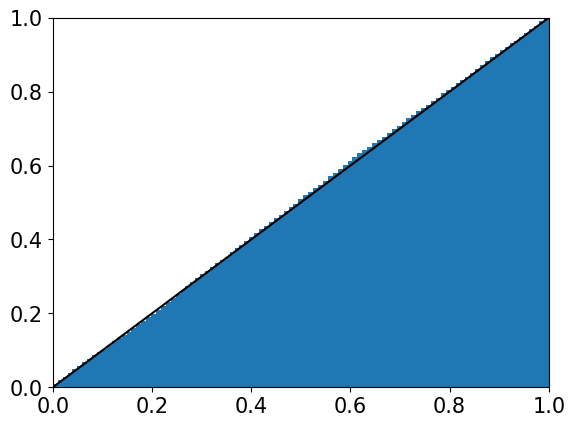

In [16]:
plt.hist(p_values, bins=n_samp+1, cumulative=True, density=True)
plt.plot([0, 1], [0, 1], c='black')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

The reported p-values of a model against random samples of that model are uniform, so these are valid p-values!

In [17]:
aei_data = np.array([centaur_a, centaur_e, centaur_i]).T 
aei_model = np.array([literature_predicted_a, literature_predicted_e, literature_predicted_i]).T
aei_kl = KLEstimator(aei_data, aei_model, normalize=True, k_samples=2)

aeiH_data = np.array([centaur_a, centaur_e, centaur_i, centaur_H]).T 
aeiH_model = np.array([literature_predicted_a, literature_predicted_e, literature_predicted_i, literature_predicted_H]).T
aeiH_kl = KLEstimator(aeiH_data, aeiH_model, normalize=True, k_samples=2)


In [18]:
%%time
aei_kl.computePValue(100_000, new_k_model=2), aeiH_kl.computePValue(100_000, new_k_model=2)

CPU times: user 3min 31s, sys: 195 ms, total: 3min 32s
Wall time: 3min 34s


(0.07285, 0.00389)

We find a non-rejectable a-e-i distribution, but a rejectable a-e-i-H distribution. Combining this with our non-rejectable H distribution, we conclude that neither the orbital nor size distribution are rejectable, but their joint distribution is. 